Data loading and Initial Exploration

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ucimlrepo import fetch_ucirepo
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def load_and_explore_data():
    print("Loading dataset from UCI ML Repository...")
    # Fetch dataset with ID 925 (Infrared Thermography Temperature)
    infrared_thermography_temperature = fetch_ucirepo(id=925)
    
    # Get features and targets as pandas dataframes
    X = infrared_thermography_temperature.data.features
    y = infrared_thermography_temperature.data.targets
    
    # Combine features and targets for exploration and preprocessing
    data = pd.concat([X, y], axis=1)
    
    print(f"Dataset shape: {data.shape}")
    
    print("\nFirst few rows:")
    print(data.head())
    
    print("\nData info:")
    print(data.info())
    
    print("\nDescriptive statistics:")
    print(data.describe())
    
    print("\nChecking for missing values:")
    missing_values = data.isnull().sum()
    print(missing_values)
    print(f"Percentage of missing values in 'Distance': {missing_values['Distance']/len(data)*100:.2f}%")
    
    # Check for correlation between target variables
    target_corr = data[['aveOralF', 'aveOralM']].corr()
    print("\nCorrelation between target variables:")
    print(target_corr)
    
    return data

Data Preprocessing with Data Visualisation and Outlier Analysis

In [56]:
def visualize_data_with_outliers(data):
    print("\nVisualizing data with outlier analysis...")
    
    # Create a figure for the visualizations
    plt.figure(figsize=(18, 15))
    
    # 1. Distribution of target variables
    plt.subplot(3, 3, 1)
    sns.histplot(data['aveOralF'], kde=True, color='blue')
    sns.histplot(data['aveOralM'], kde=True, color='red', alpha=0.6)
    plt.title('Distribution of Target Variables')
    plt.legend(['Fast Oral Temp', 'Monitor Oral Temp'])
    
    # 2. Correlation heatmap
    plt.subplot(3, 3, 2)
    numeric_data = data.select_dtypes(include=[np.number])
    correlation = numeric_data.corr()
    sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    
    # 3. Boxplot for target variables (check for outliers)
    plt.subplot(3, 3, 3)
    sns.boxplot(data=[data['aveOralF'], data['aveOralM']])
    plt.xticks([0, 1], ['Fast Oral Temp', 'Monitor Oral Temp'])
    plt.title('Boxplot of Target Variables')
    
    # 4. Scatter plot between the two targets
    plt.subplot(3, 3, 4)
    sns.scatterplot(x='aveOralF', y='aveOralM', data=data)
    plt.title('Relationship between Fast and Monitor Temperatures')
    
    # 5. Boxplot for key numeric features (check for outliers)
    plt.subplot(3, 3, 5)
    key_features = ['T_atm', 'T_RC_Max1', 'T_LC_Max1', 'T_FH_Max1']
    melted_data = pd.melt(data[key_features])
    sns.boxplot(x='variable', y='value', data=melted_data)
    plt.title('Boxplots of Key Features')
    plt.xticks(rotation=45)
    
    # 6. Relationship between ambient temperature and target variables
    plt.subplot(3, 3, 6)
    sns.scatterplot(x='T_atm', y='aveOralF', data=data, color='blue', alpha=0.6)
    sns.scatterplot(x='T_atm', y='aveOralM', data=data, color='red', alpha=0.6)
    plt.title('Effect of Room Temperature on Body Temperature')
    plt.legend(['Fast Oral Temp', 'Monitor Oral Temp'])
    

    # Save and display the figure
    plt.tight_layout()
    plt.savefig('fever_detection_visualization.png')
    plt.show()
    
    # Identify outliers using Z-score method
    outliers = {}
    for column in numeric_data.columns:
        if column not in ['aveOralF', 'aveOralM']:
            z = np.abs(stats.zscore(numeric_data[column].fillna(numeric_data[column].median())))
            outliers[column] = sum(z > 4)
    
    print("\nOutlier count by feature (|z-score| > 4):")
    for column, count in outliers.items():
        if count > 0:
            print(f"{column}: {count} outliers")
    
    # Check if splitting by room temperature might be useful
    room_temp_median = data['T_atm'].median()
    group_low = data[data['T_atm'] < room_temp_median]
    group_high = data[data['T_atm'] >= room_temp_median]
    
    print(f"\nSplitting data by room temperature (median={room_temp_median:.1f}):")
    print(f"Low temp group: {len(group_low)} samples")
    print(f"High temp group: {len(group_high)} samples")
    
    # Calculate mean target values for each group
    print("\nMean target values by room temperature group:")
    print(f"Low temp group: aveOralF={group_low['aveOralF'].mean():.2f}, aveOralM={group_low['aveOralM'].mean():.2f}")
    print(f"High temp group: aveOralF={group_high['aveOralF'].mean():.2f}, aveOralM={group_high['aveOralM'].mean():.2f}")
    
    # T-test to see if there's a significant difference
    t_stat_f, p_val_f = stats.ttest_ind(group_low['aveOralF'], group_high['aveOralF'])
    t_stat_m, p_val_m = stats.ttest_ind(group_low['aveOralM'], group_high['aveOralM'])
    
    print("\nT-test p-values for difference between groups:")
    print(f"aveOralF: p={p_val_f:.4f}")
    print(f"aveOralM: p={p_val_m:.4f}")
    
    return outliers

In [57]:
def preprocess_data(data, handle_outliers=True):
    print("\nPreprocessing data...")
    
    # Handle missing values in 'distance' column using median imputation
    distance_median = data['Distance'].median()
    data['Distance'].fillna(distance_median, inplace=True)
    print(f"Filled missing values in 'distance' column with median: {distance_median}")
    
    # Handle outliers if specified
    if handle_outliers:
        # Calculate z-scores for numeric columns
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col not in ['aveOralF', 'aveOralM']:
                z_scores = np.abs(stats.zscore(data[col].fillna(data[col].median())))
                outliers = z_scores > 4
                if sum(outliers) > 0:
                    print(f"Capping {sum(outliers)} outliers in '{col}'")
                    # Cap outliers at 3 std deviations
                    col_median = data[col].median()
                    col_std = data[col].std()
                    data.loc[outliers, col] = data.loc[outliers, col].clip(
                        lower=col_median - 3*col_std, 
                        upper=col_median + 3*col_std
                    )
    
    # Check if room temperature split is beneficial
    room_temp_median = data['T_atm'].median()
    t_stat_f, p_val_f = stats.ttest_ind(
        data[data['T_atm'] < room_temp_median]['aveOralF'],
        data[data['T_atm'] >= room_temp_median]['aveOralF']
    )
    
    # Add room temperature group as a feature if p-value is significant
    if p_val_f < 0.05:
        print("\nAdding room temperature group feature (significant difference detected)")
        data['temp_group'] = (data['T_atm'] >= room_temp_median).astype(int)
    
    # Split features and multi-output target
    X = data.drop(['aveOralF', 'aveOralM'], axis=1)
    y = data[['aveOralF', 'aveOralM']]
    
    # Identify categorical columns
    categorical_cols = ['Gender', 'Age', 'Ethnicity']
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Create preprocessing pipelines for both numeric and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, preprocessor

Multi-Output Regression Training / Evaluation

In [58]:
def train_multioutput_models(X_train, X_test, y_train, y_test, preprocessor):
    """Train and evaluate multiple models for predicting both target variables."""
    print("Training multiple models...")
    
    # Define base models to test
    base_models = {
        'Linear Regression': MultiOutputRegressor(LinearRegression()),
        'Ridge Regression': MultiOutputRegressor(Ridge(alpha=1.0)),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),  # Native multi-output support
        'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
    }
    
    results = {}
    best_score = -float('inf')
    best_model_name = None
    
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics for each target
        rmse_f = np.sqrt(mean_squared_error(y_test['aveOralF'], y_pred[:, 0]))
        rmse_m = np.sqrt(mean_squared_error(y_test['aveOralM'], y_pred[:, 1]))
        r2_f = r2_score(y_test['aveOralF'], y_pred[:, 0])
        r2_m = r2_score(y_test['aveOralM'], y_pred[:, 1])
        
        avg_rmse = (rmse_f + rmse_m) / 2
        avg_r2 = (r2_f + r2_m) / 2
        
        print(f"{name} Results:")
        print(f"aveOralF - RMSE: {rmse_f:.4f}, R²: {r2_f:.4f}")
        print(f"aveOralM - RMSE: {rmse_m:.4f}, R²: {r2_m:.4f}")
        print(f"Average - RMSE: {avg_rmse:.4f}, R²: {avg_r2:.4f}")
        
        results[name] = {
            'pipeline': pipeline,
            'rmse': avg_rmse,
            'r2': avg_r2
        }
        
        # Track best model
        if avg_r2 > best_score:
            best_score = avg_r2
            best_model_name = name
    
    print(f"\nBest model: {best_model_name} with R² = {best_score:.4f}")
    
    return results, best_model_name

Hyperparameter Tuning with GridSearch

In [59]:
def tune_best_multioutput_model(X_train, y_train, preprocessor, best_model_name):
    """Tune hyperparameters of the best performing model."""
    print(f"\nTuning hyperparameters for {best_model_name}...")
    
    # Define parameter grid based on the best model
    if best_model_name == 'Random Forest':
        model = RandomForestRegressor(random_state=42)  # Native multi-output support
        param_grid = {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    elif best_model_name == 'Gradient Boosting':
        model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
        param_grid = {
            'model__estimator__n_estimators': [100, 200, 300],
            'model__estimator__learning_rate': [0.01, 0.1, 0.2],
            'model__estimator__max_depth': [1, 4, 7]
        }
    elif best_model_name == 'Ridge Regression':
        model = MultiOutputRegressor(Ridge())
        param_grid = {
            'model__estimator__alpha': [0.1, 1.0, 10.0, 100.0],
            'model__estimator__fit_intercept': [True, False]
        }
    else:  # Linear Regression or default
        model = MultiOutputRegressor(LinearRegression())
        param_grid = {
            'model__estimator__fit_intercept': [True, False]
        }
    
    # Create pipeline with preprocessing
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    
    print("Starting grid search...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {-grid_search.best_score_:.4f} (MSE)")
    
    return grid_search.best_estimator_

In [60]:
def train_room_temp_split_models(data):
    """Train separate models for different room temperature groups if beneficial."""
    print("\nInvestigating room temperature split approach...")
    
    # Calculate the median room temperature
    room_temp_median = data['T_atm'].median()
    
    # Split data by room temperature
    low_temp_data = data[data['T_atm'] < room_temp_median]
    high_temp_data = data[data['T_atm'] >= room_temp_median]
    
    print(f"Low temperature group (<{room_temp_median:.2f}): {len(low_temp_data)} samples")
    print(f"High temperature group (≥{room_temp_median:.2f}): {len(high_temp_data)} samples")
    
    # Check if there's a significant difference in target variables between groups
    t_stat_f, p_val_f = stats.ttest_ind(
        low_temp_data['aveOralF'], 
        high_temp_data['aveOralF']
    )
    
    t_stat_m, p_val_m = stats.ttest_ind(
        low_temp_data['aveOralM'], 
        high_temp_data['aveOralM']
    )
    
    print(f"T-test p-values: aveOralF: {p_val_f:.4f}, aveOralM: {p_val_m:.4f}")
    
    # If either p-value is significant, train separate models
    if p_val_f < 0.05 or p_val_m < 0.05:
        print("Significant difference detected between temperature groups. Training separate models...")
        
        results = {}
        
        # Process both groups
        for name, group_data in [("Low Temp", low_temp_data), ("High Temp", high_temp_data)]:
            print(f"\nTraining model for {name} group...")
            
            # Preprocess data
            X = group_data.drop(['aveOralF', 'aveOralM'], axis=1)
            y = group_data[['aveOralF', 'aveOralM']]
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Create and fit preprocessor
            categorical_cols = ['Gender', 'Age', 'Ethnicity']
            numeric_cols = [col for col in X.columns if col not in categorical_cols]
            
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), numeric_cols),
                    ('cat', Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore'))
                    ]), categorical_cols)
                ]
            )
            
            # Train Random Forest model (typically good performer)
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', RandomForestRegressor(n_estimators=200, random_state=42))
            ])
            
            # Fit model
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics for each target
            rmse_f = np.sqrt(mean_squared_error(y_test['aveOralF'], y_pred[:, 0]))
            rmse_m = np.sqrt(mean_squared_error(y_test['aveOralM'], y_pred[:, 1]))
            r2_f = r2_score(y_test['aveOralF'], y_pred[:, 0])
            r2_m = r2_score(y_test['aveOralM'], y_pred[:, 1])
            
            print(f"Results for {name} group:")
            print(f"aveOralF - RMSE: {rmse_f:.4f}, R²: {r2_f:.4f}")
            print(f"aveOralM - RMSE: {rmse_m:.4f}, R²: {r2_m:.4f}")
            print(f"Average - RMSE: {(rmse_f + rmse_m)/2:.4f}, R²: {(r2_f + r2_m)/2:.4f}")
            
            results[name] = {
                'pipeline': pipeline,
                'rmse': (rmse_f + rmse_m)/2,
                'r2': (r2_f + r2_m)/2
            }
        
        return results, True
    else:
        print("No significant difference between temperature groups. A single model is sufficient.")
        return None, False

In [61]:
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    """
    Generate plots comparing predicted values against actual values.
    
    Parameters:
    -----------
    y_true : pandas.DataFrame
        DataFrame containing actual target values
    y_pred : numpy.ndarray
        Array containing predicted target values
    model_name : str
        Name of the model used for predictions
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    targets = ['aveOralF', 'aveOralM']
    titles = ['Fast Oral Temperature', 'Monitor Oral Temperature']
    
    for i, (target, title) in enumerate(zip(targets, titles)):
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true[target], y_pred[:, i]))
        r2 = r2_score(y_true[target], y_pred[:, i])
        mae = mean_absolute_error(y_true[target], y_pred[:, i])
        
        # Get min and max for plot limits
        min_val = min(y_true[target].min(), y_pred[:, i].min())
        max_val = max(y_true[target].max(), y_pred[:, i].max())
        
        # Add some padding to the limits
        padding = (max_val - min_val) * 0.05
        min_val -= padding
        max_val += padding
        
        # Create scatter plot
        axes[i].scatter(y_true[target], y_pred[:, i], alpha=0.6)
        
        # Add diagonal line (perfect prediction)
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Set equal aspect ratio
        axes[i].set_aspect('equal')
        
        # Set axis limits
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
        
        # Add labels and title
        axes[i].set_xlabel('Actual Temperature (°F)')
        axes[i].set_ylabel('Predicted Temperature (°F)')
        axes[i].set_title(f'{title} Prediction Accuracy')
        
        # Add metrics as text
        metrics_text = f'RMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAE: {mae:.4f}'
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    plt.suptitle(f'Predicted vs. Actual Temperatures - {model_name}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'prediction_accuracy_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

In [ ]:
def plot_dec_tree(pipeline_model, data):
    """
    Plot a decision tree model from a pipeline containing a MultiOutputRegressor
    with GradientBoostingRegressor
    """
    # Extract the actual gradient boosting models from the pipeline
    multioutput_model = pipeline_model.named_steps['model']
    
    # The first estimator in the MultiOutputRegressor 
    # (for the first target variable)
    gb_model = multioutput_model.estimators_[0]
    
    plt.figure(figsize=(11, 20), dpi=300)

    for i, tree_idx in enumerate([0, 2, 49, 99]):
        if tree_idx < len(gb_model.estimators_):  # Make sure tree index is valid
            plt.subplot(4, 1, i+1)
            # Get the tree array and extract the actual tree object from it
            tree_array = gb_model.estimators_[tree_idx]
            tree = tree_array[0]  # Extract the individual tree from the array
            plot_tree(tree, 
                    feature_names=data.columns,
                    impurity=False,
                    filled=True, 
                    rounded=True,
                    precision=2,
                    fontsize=12)
            plt.title(f'Tree {tree_idx + 1}')

    plt.suptitle('Decision Trees from GradientBoosting', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

=== FEVER DETECTION MODEL IMPLEMENTATION ===

=== STEP 1: LOADING AND EXPLORING DATA ===
Loading dataset from UCI ML Repository...
Dataset shape: (1020, 35)

First few rows:
   Gender    Age                  Ethnicity  ...  T_OR_Max1  aveOralF  aveOralM
0    Male  41-50                      White  ...    35.6525     36.85     36.59
1  Female  31-40  Black or African-American  ...    35.1075     37.00     37.19
2  Female  21-30                      White  ...    35.8850     37.20     37.34
3  Female  21-30  Black or African-American  ...    34.9825     36.85     37.09
4    Male  18-20                      White  ...    35.6175     36.80     37.04

[5 rows x 35 columns]

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   ob

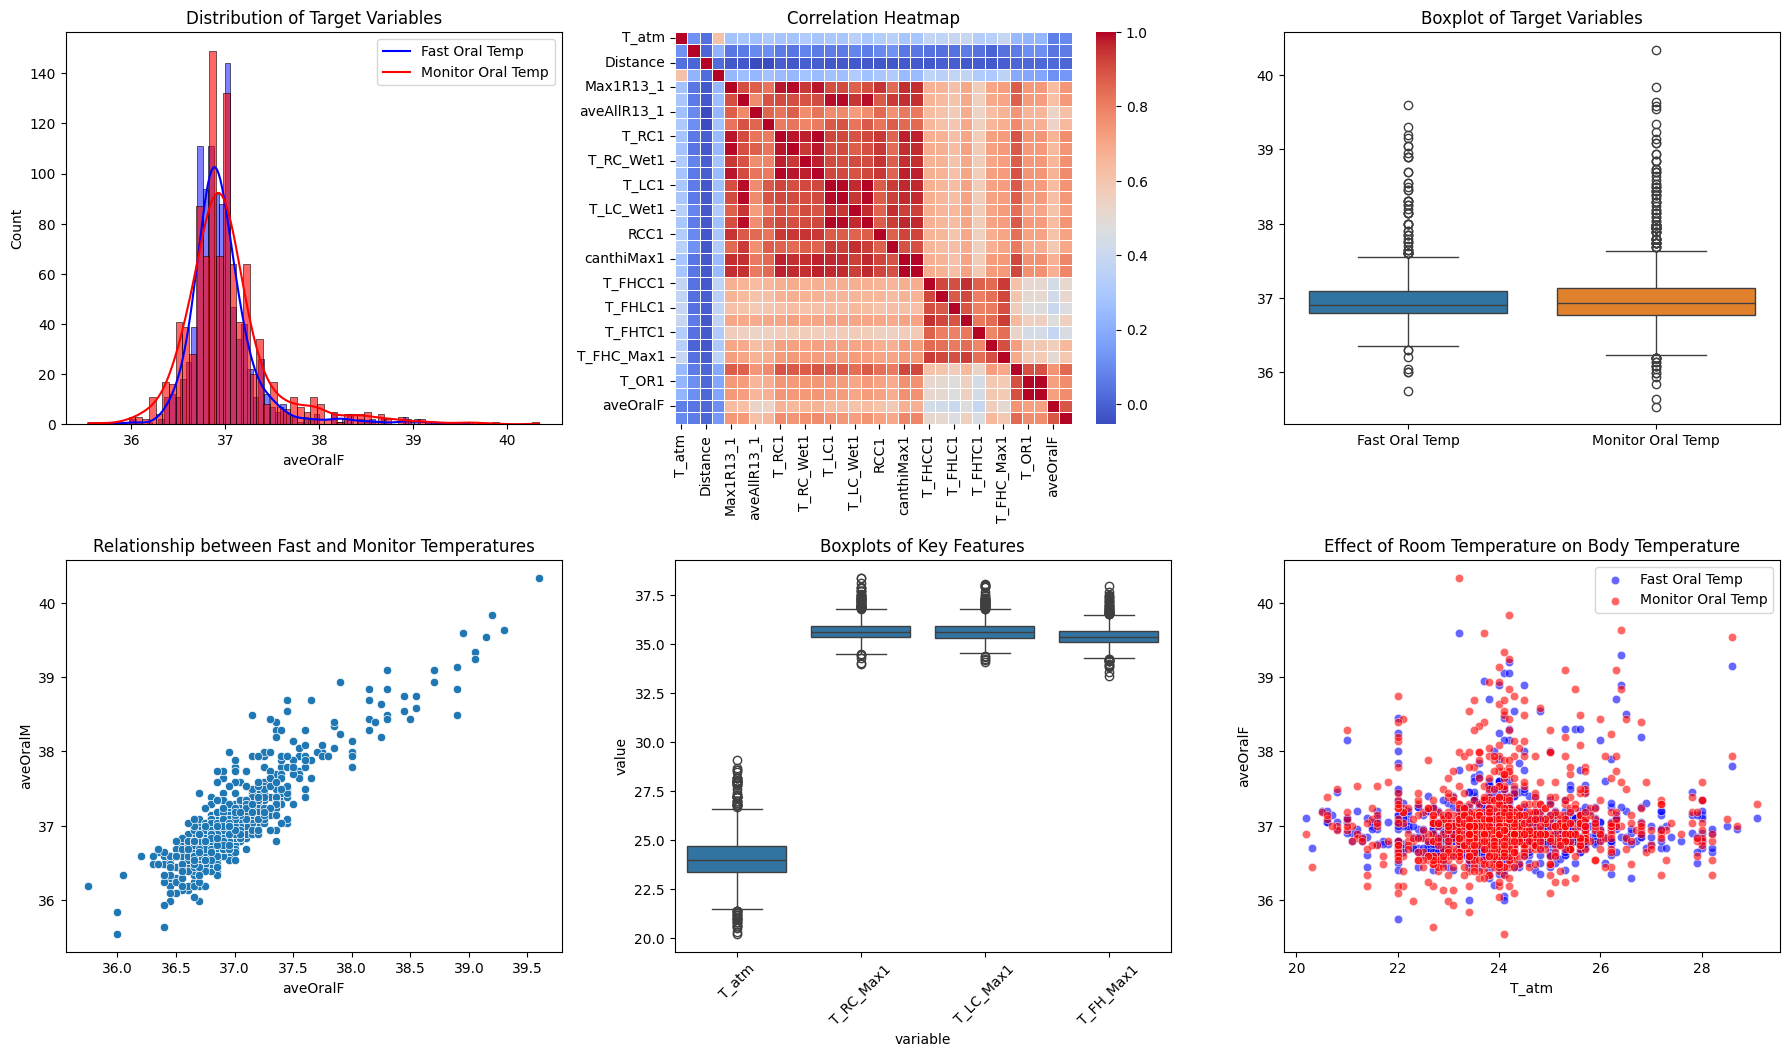


Outlier count by feature (|z-score| > 4):
Distance: 1 outliers
T_offset1: 5 outliers
Max1R13_1: 3 outliers
Max1L13_1: 6 outliers
aveAllR13_1: 1 outliers
aveAllL13_1: 3 outliers
T_RC1: 4 outliers
T_RC_Dry1: 4 outliers
T_RC_Wet1: 3 outliers
T_RC_Max1: 4 outliers
T_LC1: 6 outliers
T_LC_Dry1: 6 outliers
T_LC_Wet1: 4 outliers
T_LC_Max1: 6 outliers
RCC1: 4 outliers
LCC1: 4 outliers
canthiMax1: 6 outliers
canthi4Max1: 5 outliers
T_FHCC1: 3 outliers
T_FHRC1: 4 outliers
T_FHLC1: 3 outliers
T_FHBC1: 3 outliers
T_FHTC1: 3 outliers
T_FH_Max1: 2 outliers
T_FHC_Max1: 4 outliers
T_Max1: 5 outliers
T_OR1: 1 outliers
T_OR_Max1: 1 outliers

Splitting data by room temperature (median=24.0):
Low temp group: 450 samples
High temp group: 570 samples

Mean target values by room temperature group:
Low temp group: aveOralF=36.95, aveOralM=36.97
High temp group: aveOralF=37.00, aveOralM=37.07

T-test p-values for difference between groups:
aveOralF: p=0.0281
aveOralM: p=0.0021

=== STEP 3: PREPROCESSING DATA =

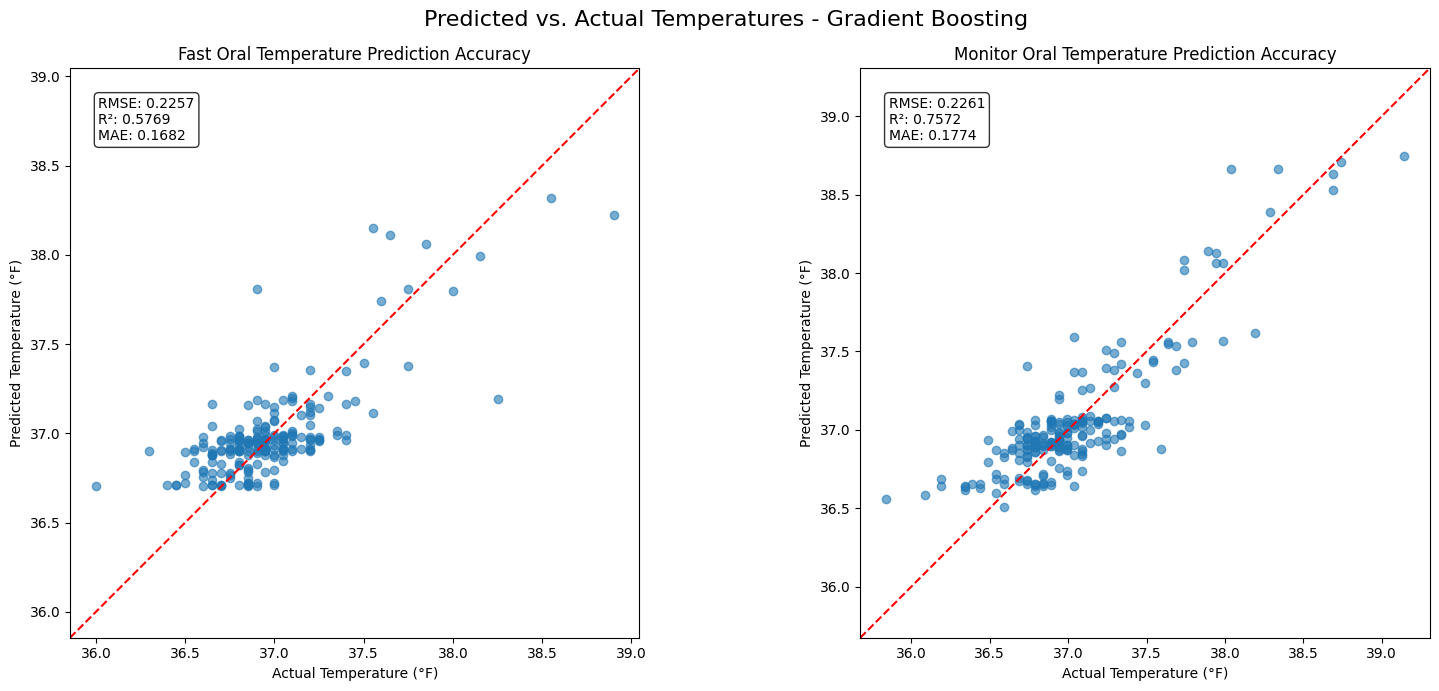


=== STEP 8: ANALYZING FEATURE IMPORTANCE ===

=== STEP 9: CONCLUSION ===
Best overall model: Gradient Boosting


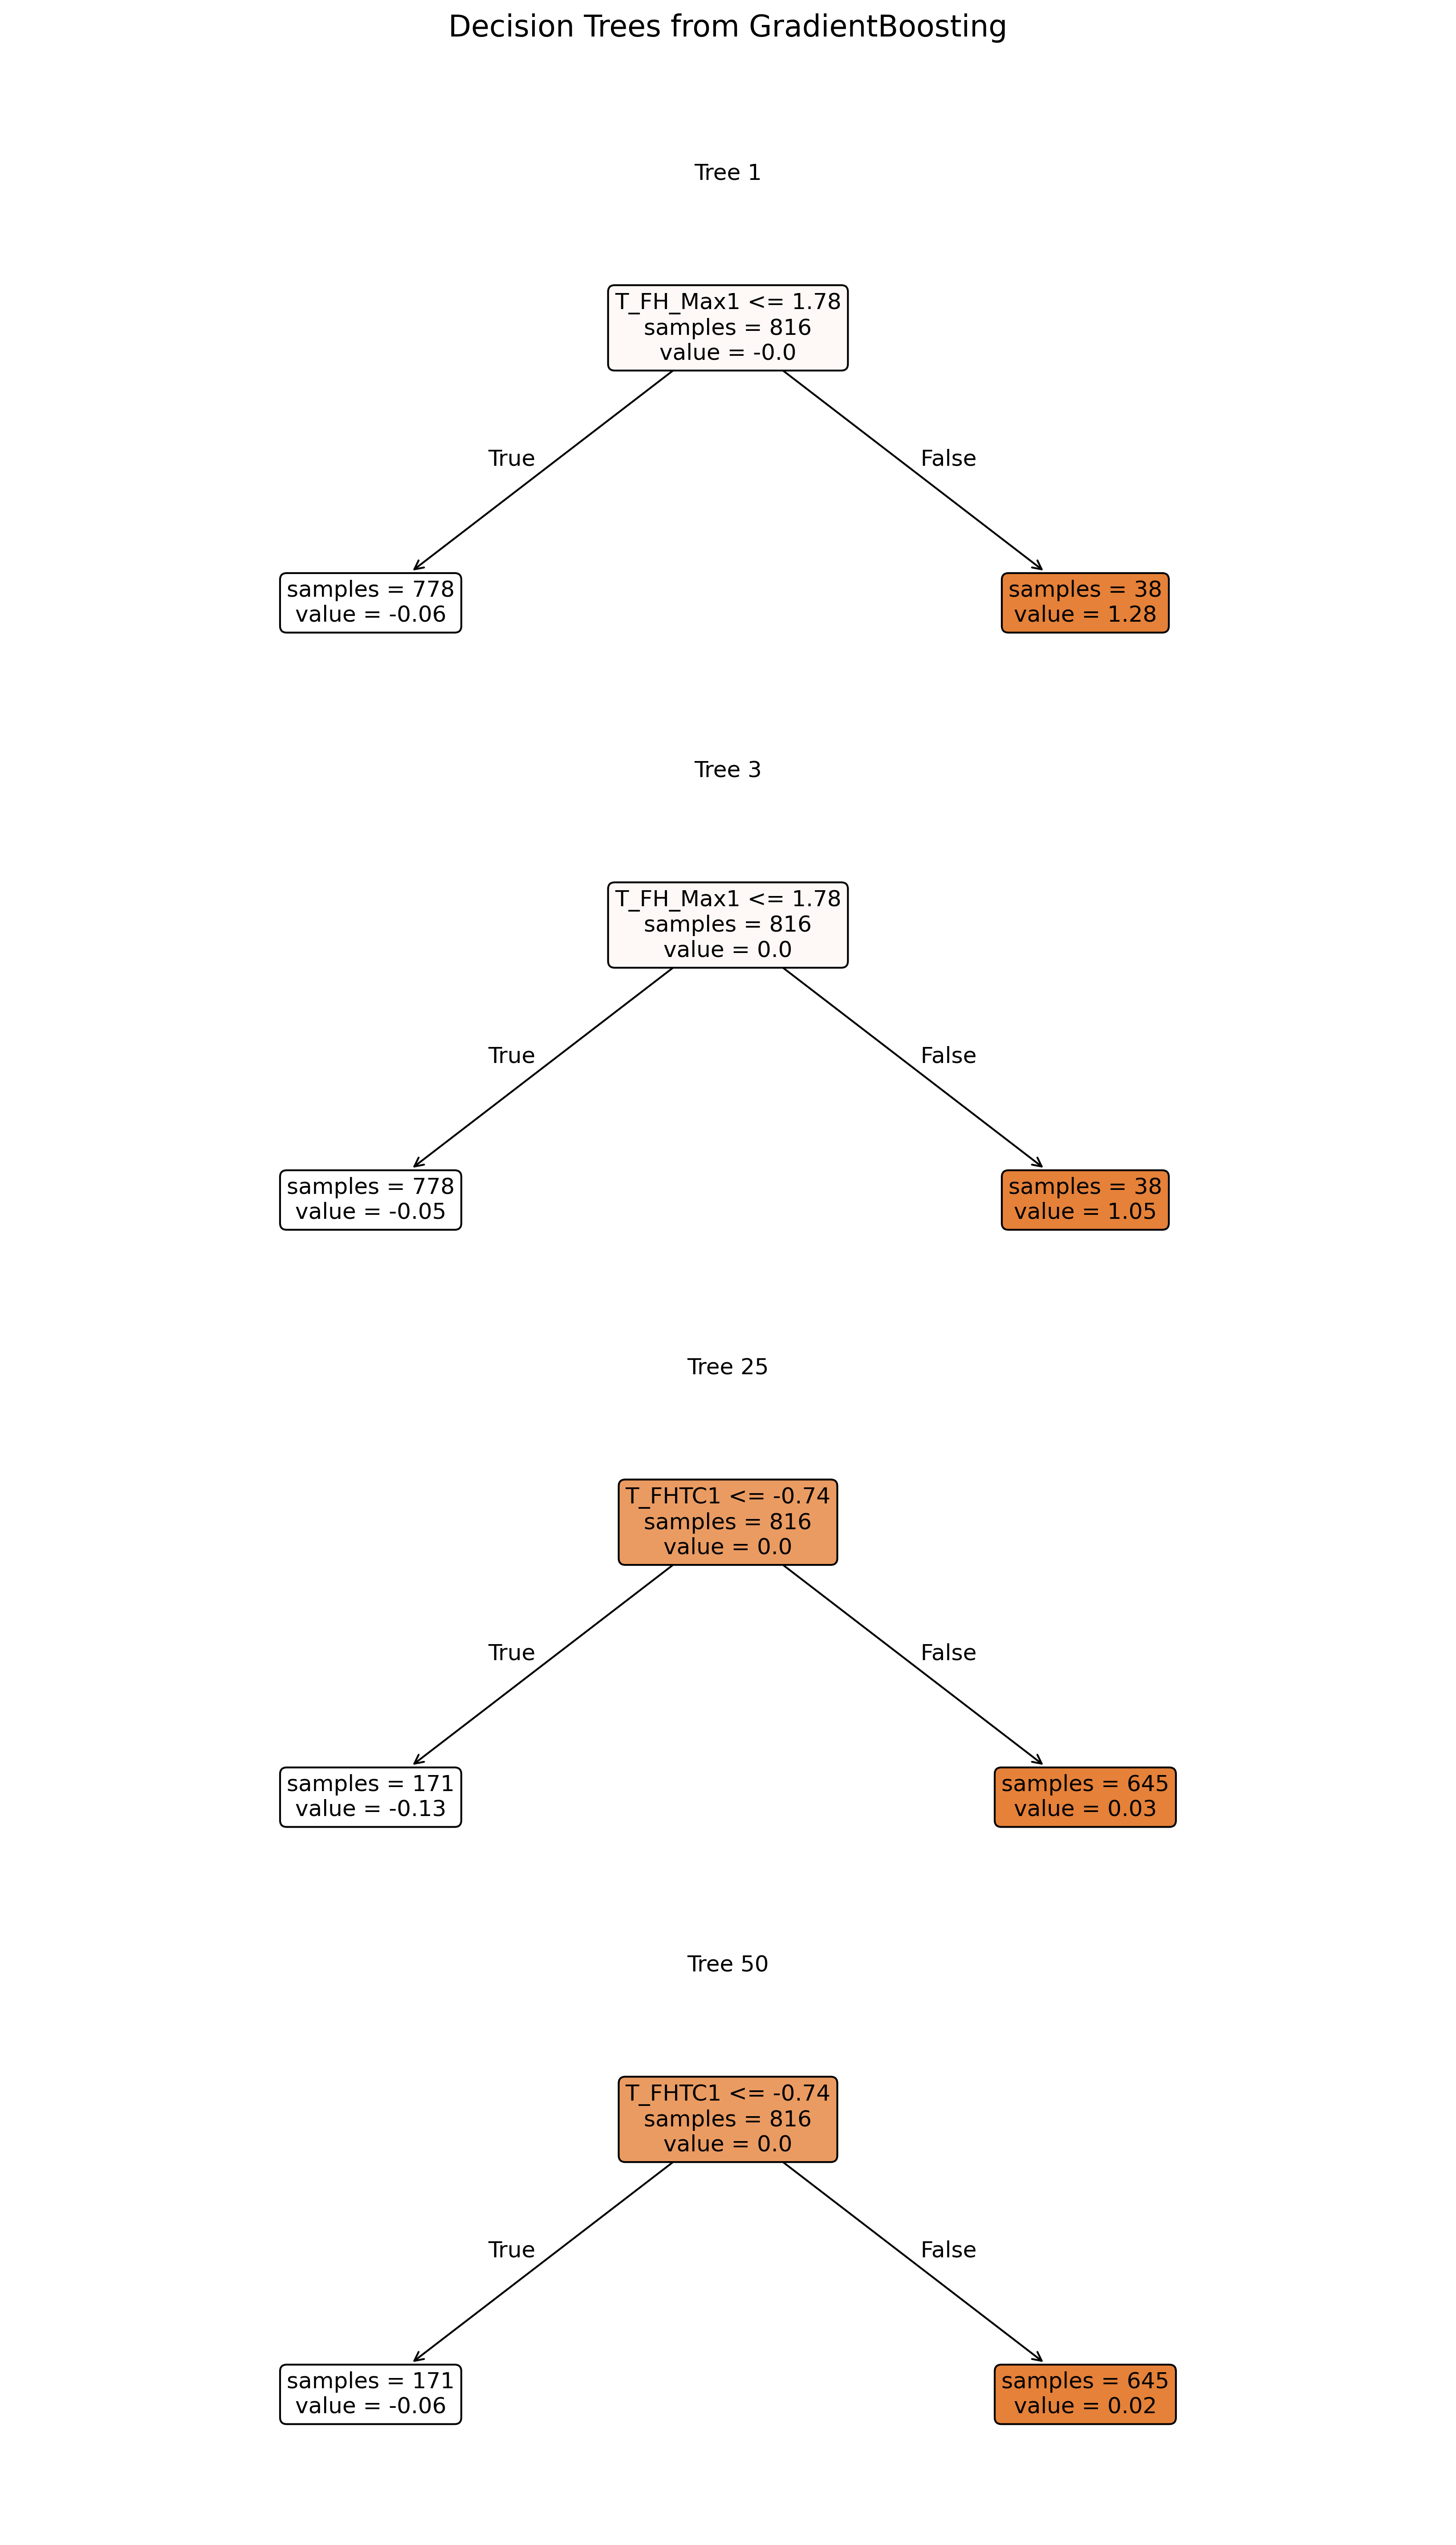


Analysis complete!


In [63]:
# Main function to run the complete fever detection analysis
def main():
    print("=== FEVER DETECTION MODEL IMPLEMENTATION ===")
    
    # Step 1: Load and explore data
    print("\n=== STEP 1: LOADING AND EXPLORING DATA ===")
    data = load_and_explore_data()
    
    # Step 2: Visualize data and analyze outliers
    print("\n=== STEP 2: VISUALIZING DATA AND ANALYZING OUTLIERS ===")
    outliers = visualize_data_with_outliers(data)
    
    # Step 3: Preprocess data
    print("\n=== STEP 3: PREPROCESSING DATA ===")
    X_train, X_test, y_train, y_test, preprocessor = preprocess_data(data)
    
    # Step 4: Train and evaluate multiple models
    print("\n=== STEP 4: TRAINING AND EVALUATING MODELS ===")
    model_results, best_model_name = train_multioutput_models(X_train, X_test, y_train, y_test, preprocessor)
    
    # Step 5: Tune the best model
    print("\n=== STEP 5: TUNING THE BEST MODEL ===")
    best_tuned_model = tune_best_multioutput_model(X_train, y_train, preprocessor, best_model_name)
    
    # Step 6: Final evaluation of the tuned model
    print("\n=== STEP 6: FINAL EVALUATION OF TUNED MODEL ===")
    y_pred = best_tuned_model.predict(X_test)
    
    for i, target in enumerate(['aveOralF', 'aveOralM']):
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"{target} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Add visualisation of predicted vs. actual values
    print("\n=== VISUALIZING PREDICTION ACCURACY ===")
    plot_predicted_vs_actual(y_test, y_pred, best_model_name)
    
    # Step 7: Investigate room temperature splitting approach
    #print("\n=== STEP 7: INVESTIGATING ROOM TEMPERATURE SPLIT APPROACH ===")
    #temp_split_results, is_split_beneficial = train_room_temp_split_models(data)
    
    # Step 8: Extract feature importance
    print("\n=== STEP 8: ANALYZING FEATURE IMPORTANCE ===")
    if hasattr(best_tuned_model.named_steps['model'], 'feature_importances_') or hasattr(best_tuned_model.named_steps['model'], 'coef_'):
        feature_names = []
        for name, transformer, cols in preprocessor.transformers_:
            if name == 'cat':
                feature_names.extend(transformer.named_steps['onehot'].get_feature_names_out(cols))
            else:
                feature_names.extend(cols)
                
        if hasattr(best_tuned_model.named_steps['model'], 'feature_importances_'):
            importances = best_tuned_model.named_steps['model'].feature_importances_
            print("\nFeature importances:")
        elif hasattr(best_tuned_model.named_steps['model'], 'coef_'):
            importances = np.mean(np.abs(best_tuned_model.named_steps['model'].coef_), axis=0)
            print("\nFeature coefficients (absolute mean):")
            
        # Sort features by importance
        indices = np.argsort(importances)[-15:]
        for i in reversed(indices):
            if i < len(feature_names):
                print(f"{feature_names[i]}: {importances[i]:.4f}")

    
    
    # Step 9: Conclusion
    print("\n=== STEP 9: CONCLUSION ===")
    print(f"Best overall model: {best_model_name}")

    if(best_model_name == 'Gradient Boosting'):
        plot_dec_tree(best_tuned_model, X_train)
    
   # if is_split_beneficial:
   #     best_split = max(temp_split_results.items(), key=lambda x: x[1]['r2'])[0]
   #     print(f"Room temperature splitting approach is beneficial. Best performance with {best_split} group.")
   #     print(f"Split model R²: {temp_split_results[best_split]['r2']:.4f}")
  #  else:
   #     print("Room temperature splitting approach did not show significant benefits.")
        
    print("\nAnalysis complete!")

# Run the main function
if __name__ == "__main__":
    main()